#### [recommendation system](https://www.kaggle.com/gspmoreira/recommender-systems-in-python-101) (level is little high, use of classes)

[1. dataset](https://www.kaggle.com/gspmoreira/articles-sharing-reading-from-cit-deskdrop) <br>
[2. svd](https://medium.com/@m_n_malaeb/singular-value-decomposition-svd-in-recommender-systems-for-non-math-statistics-programming-4a622de653e9) <br>
[3. surprice package python for recomemnder](https://github.com/NicolasHug/Surprise) <br>
[4. coursera minessota using python](https://medium.com/@tomar.ankur287/non-personalised-recommender-system-in-python-42921cd6f971)<br>
[5. google doc ](https://docs.google.com/document/d/16qfJTQeWSArr39ucn8gVswBQpuwCSjGOBIIZyfZ4_Bo/edit)

In [1]:
import numpy as np
import scipy
import pandas as pd
import math
import random
import sklearn
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt

In [23]:
%matplotlib inline

In [2]:
import dask.dataframe as dd
articles = dd.read_csv("shared_articles.csv")

In [77]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)

In [81]:
#import dask.array as da
#x = da.random.random((20000,20000), chunks= (1000,1000)).persist()
print("here is the type of x variable which is a dask array ", type(x))
y = (x+x.T)

here is the type of x variable which is a dask array  <class 'dask.array.core.Array'>


dask.array<transpose, shape=(20000, 20000), dtype=float64, chunksize=(1000, 1000)>


[1. dask for scheduling](https://www.youtube.com/watch?v=hiPvmeLhInw)<br>
[2. dask graph in local](http://localhost:8787/status) <br>
[3. using mutiple cores](https://www.youtube.com/watch?v=ZWRuOkH0qkY)

In [ ]:
import dask.array as da
import graphviz
x = da.ones((15, 15), chunks=(5, 5))

y = x + x.T

# y.compute()
y.visualize(filename='transpose.svg')

In [6]:
articles_df = pd.read_csv('shared_articles.csv')
display(articles_df.head(1))
articles_df = articles_df[articles_df.eventType == "CONTENT SHARED"]
articles_df.head()
articles_df.shape
#This web content was shared by a user and content event type if content shared. CONTENT REMOVED is dropped for simplicity purposes. 

,timestamp,eventType,contentId,authorPersonId,authorSessionId,authorUserAgent,authorRegion,authorCountry,contentType,url,title,text,lang
0,1459192779,CONTENT REMOVED,-6451309518266745024,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en


(3047, 13)

In [4]:
interactions_df = pd.read_csv("users_interactions.csv")
interactions_df.head()
#What is the interraction of the shared content can be seen here. 

,timestamp,eventType,contentId,personId,sessionId,userAgent,userRegion,userCountry
0,1465413032,VIEW,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN
1,1465412560,VIEW,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US
2,1465416190,VIEW,310515487419366995,-1130272294246983140,2631864456530402479,NaN,NaN,NaN
3,1465413895,FOLLOW,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN
4,1465412290,VIEW,-7820640624231356730,-445337111692715325,5611481178424124714,NaN,NaN,NaN


In [7]:
event_type_strength = {
   'VIEW': 1.0,
   'LIKE': 2.0, 
   'BOOKMARK': 2.5, 
   'FOLLOW': 3.0,
   'COMMENT CREATED': 4.0,  
}
# For each we are givng eventStrength depending on event type using lambda function. 
interactions_df['eventStrength'] = interactions_df['eventType'].apply(lambda x: event_type_strength[x])
# How does an lambda function work. 

In [14]:
# group by person and content. 
users_interactions_count_df =  interactions_df.groupby(['personId', 'contentId']).size().groupby(["personId"]).size()
users_interactions_count_df[0:5]

personId
-9223121837663643404    43
-9212075797126931087     5
-9207251133131336884     7
-9199575329909162940    11
-9196668942822132778     7
dtype: int64

In [43]:
type(users_interactions_count_df[users_interactions_count_df >= 5].reset_index()["personId"])

pandas.core.series.Series

In [44]:
type(users_interactions_count_df[users_interactions_count_df >= 5].reset_index()[["personId"]])

pandas.core.frame.DataFrame

In [15]:
users_with_enough_interactions_df = users_interactions_count_df[users_interactions_count_df >= 5].reset_index()[["personId"]]
display(users_with_enough_interactions_df.head())
print("person with more than 5 interactions : {}" .format(len(users_with_enough_interactions_df)))
print("person with more than 5 interactions : %d" %(len(users_with_enough_interactions_df)))

,personId
0,-9223121837663643404
1,-9212075797126931087
2,-9207251133131336884
3,-9199575329909162940
4,-9196668942822132778


person with more than 5 interactions : 1140
person with more than 5 interactions : 1140


In [16]:
interactions_from_selected_users_df = interactions_df.merge(users_with_enough_interactions_df, 
               how = 'right',
               left_on = 'personId',
               right_on = 'personId')
interactions_from_selected_users_df.head()
display(len(interactions_from_selected_users_df))
display(len(interactions_df))


69868

72312

log 1 to the base 2 is zero, so to avoid this we do a log transformation. 

In [ ]:
interactions_from_selected_users_df.groupby(["", ""]) [[""]].sum(). apply(function_name).reset_in
interactions_from_selected_users_df.groupby()[].sum(). apply(fucn)

In [17]:
interactions_from_selected_users_df.head()

,timestamp,eventType,contentId,personId,sessionId,userAgent,userRegion,userCountry,eventStrength
0,1465413032,VIEW,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN,1.0
1,1465413046,VIEW,-3499919498720038879,-8845298781299428018,1264196770339959068,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5...,SP,BR,1.0
2,1464190235,VIEW,6437568358552101410,-8845298781299428018,-1157447994463607871,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_4...,SP,BR,1.0
3,1459429221,VIEW,-4760639635023250284,-8845298781299428018,-5149610736659242149,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_4...,SP,BR,1.0
4,1459274156,VIEW,-6142462826726347616,-8845298781299428018,-6283148774987755959,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_4...,SP,BR,1.0


In [18]:
def smooth_user_preference(x):
    return math.log(1+x, 2)
    
interactions_full_df = interactions_from_selected_users_df \
                    .groupby(['personId', 'contentId'])['eventStrength'].sum() \
                    .apply(smooth_user_preference).reset_index()
print('# of unique user/item interactions: %d' % len(interactions_full_df))
interactions_full_df.head(5)
# of interaction type strength and apply a log transformation to smooth the distribution.

# of unique user/item interactions: 39106


,personId,contentId,eventStrength
0,-9223121837663643404,-8949113594875411859,1.000000
1,-9223121837663643404,-8377626164558006982,1.000000
2,-9223121837663643404,-8208801367848627943,1.000000
3,-9223121837663643404,-8187220755213888616,1.000000
4,-9223121837663643404,-7423191370472335463,3.169925


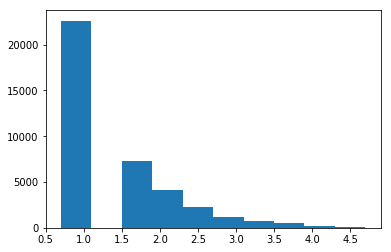

In [48]:
#mywork
plt.hist(interactions_full_df["eventStrength"], bins= 10 ,range=[0.7,4.7], bottom= 6)
plt.show()

In [9]:
#mywork
math.log(1, 2)
#base 2

0.0

In [67]:
#mywork
interactions_from_selected_users_df \
                    .groupby(['personId', 'contentId'])[['eventStrength']].sum().reset_index()
    ##[[]]  gives a pandas.dataframe
    ##[] gives a pandas.series

,personId,contentId,eventStrength
0,-9223121837663643404,-8949113594875411859,1.0
1,-9223121837663643404,-8377626164558006982,1.0
2,-9223121837663643404,-8208801367848627943,1.0
3,-9223121837663643404,-8187220755213888616,1.0
4,-9223121837663643404,-7423191370472335463,8.0
5,-9223121837663643404,-7331393944609614247,1.0
6,-9223121837663643404,-6872546942144599345,1.0
7,-9223121837663643404,-6728844082024523434,1.0
8,-9223121837663643404,-6590819806697898649,1.0
9,-9223121837663643404,-6558712014192834002,2.0


In [49]:
interactions_train_df, interactions_test_df = train_test_split(interactions_full_df,
                                   stratify=interactions_full_df['personId'], 
                                   test_size=0.20,
                                   random_state=42)

Cross-validation techniques. We are using here a simple cross-validation approach named holdout,

In [50]:
print('# interactions on Train set: %d' % len(interactions_train_df))
print('# interactions on Test set: %d' % len(interactions_test_df))

# interactions on Train set: 31284
# interactions on Test set: 7822


Indexing speeds up searches

In [51]:
interactions_full_indexed_df = interactions_full_df.set_index('personId')
interactions_train_indexed_df = interactions_train_df.set_index('personId')
interactions_test_indexed_df = interactions_test_df.set_index('personId')

In [52]:
interactions_full_df.head()

,personId,contentId,eventStrength
0,-9223121837663643404,-8949113594875411859,1.000000
1,-9223121837663643404,-8377626164558006982,1.000000
2,-9223121837663643404,-8208801367848627943,1.000000
3,-9223121837663643404,-8187220755213888616,1.000000
4,-9223121837663643404,-7423191370472335463,3.169925


In [54]:
def get_items_interacted(person_id, interactions_df):
    # Get the user's data and merge in the movie information.
    interacted_items = interactions_df.loc[person_id]['contentId']
    return set(interacted_items if type(interacted_items) == pd.Series else [interacted_items])

In [55]:
#Top-N accuracy metrics consts
EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS = 100

class ModelEvaluator:


    def get_not_interacted_items_sample(self, person_id, sample_size, seed=42):
        interacted_items = get_items_interacted(person_id, interactions_full_indexed_df)
        all_items = set(articles_df['contentId'])
        non_interacted_items = all_items - interacted_items

        random.seed(seed)
        non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
        return set(non_interacted_items_sample)

    def _verify_hit_top_n(self, item_id, recommended_items, topn):        
            try:
                index = next(i for i, c in enumerate(recommended_items) if c == item_id)
            except:
                index = -1
            hit = int(index in range(0, topn))
            return hit, index

    def evaluate_model_for_user(self, model, person_id):
        #Getting the items in test set
        interacted_values_testset = interactions_test_indexed_df.loc[person_id]
        if type(interacted_values_testset['contentId']) == pd.Series:
            person_interacted_items_testset = set(interacted_values_testset['contentId'])
        else:
            person_interacted_items_testset = set([int(interacted_values_testset['contentId'])])  
        interacted_items_count_testset = len(person_interacted_items_testset) 

        #Getting a ranked recommendation list from a model for a given user
        person_recs_df = model.recommend_items(person_id, 
                                               items_to_ignore=get_items_interacted(person_id, 
                                                                                    interactions_train_indexed_df), 
                                               topn=10000000000)

        hits_at_5_count = 0
        hits_at_10_count = 0
        #For each item the user has interacted in test set
        for item_id in person_interacted_items_testset:
            #Getting a random sample (100) items the user has not interacted 
            #(to represent items that are assumed to be no relevant to the user)
            non_interacted_items_sample = self.get_not_interacted_items_sample(person_id, 
                                                                          sample_size=EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS, 
                                                                          seed=item_id%(2**32))

            #Combining the current interacted item with the 100 random items
            items_to_filter_recs = non_interacted_items_sample.union(set([item_id]))

            #Filtering only recommendations that are either the interacted item or from a random sample of 100 non-interacted items
            valid_recs_df = person_recs_df[person_recs_df['contentId'].isin(items_to_filter_recs)]                    
            valid_recs = valid_recs_df['contentId'].values
            #Verifying if the current interacted item is among the Top-N recommended items
            hit_at_5, index_at_5 = self._verify_hit_top_n(item_id, valid_recs, 5)
            hits_at_5_count += hit_at_5
            hit_at_10, index_at_10 = self._verify_hit_top_n(item_id, valid_recs, 10)
            hits_at_10_count += hit_at_10

        #Recall is the rate of the interacted items that are ranked among the Top-N recommended items, 
        #when mixed with a set of non-relevant items
        recall_at_5 = hits_at_5_count / float(interacted_items_count_testset)
        recall_at_10 = hits_at_10_count / float(interacted_items_count_testset)

        person_metrics = {'hits@5_count':hits_at_5_count, 
                          'hits@10_count':hits_at_10_count, 
                          'interacted_count': interacted_items_count_testset,
                          'recall@5': recall_at_5,
                          'recall@10': recall_at_10}
        return person_metrics

    def evaluate_model(self, model):
        #print('Running evaluation for users')
        people_metrics = []
        for idx, person_id in enumerate(list(interactions_test_indexed_df.index.unique().values)):
            #if idx % 100 == 0 and idx > 0:
            #    print('%d users processed' % idx)
            person_metrics = self.evaluate_model_for_user(model, person_id)  
            person_metrics['_person_id'] = person_id
            people_metrics.append(person_metrics)
        print('%d users processed' % idx)

        detailed_results_df = pd.DataFrame(people_metrics) \
                            .sort_values('interacted_count', ascending=False)
        
        global_recall_at_5 = detailed_results_df['hits@5_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        global_recall_at_10 = detailed_results_df['hits@10_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        
        global_metrics = {'modelName': model.get_model_name(),
                          'recall@5': global_recall_at_5,
                          'recall@10': global_recall_at_10}    
        return global_metrics, detailed_results_df
    
model_evaluator = ModelEvaluator()   

In [57]:
#Computes the most popular items
item_popularity_df = interactions_full_df.groupby('contentId')['eventStrength'].sum().sort_values(ascending=False).reset_index()
item_popularity_df.head(5)

,contentId,eventStrength
0,-4029704725707465084,307.733799
1,-6783772548752091658,233.762157
2,-133139342397538859,228.024567
3,-8208801367848627943,197.107608
4,-6843047699859121724,193.825208


In [58]:
class PopularityRecommender:
    
    MODEL_NAME = 'Popularity'
    
    def __init__(self, popularity_df, items_df=None):
        self.popularity_df = popularity_df
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        # Recommend the more popular items that the user hasn't seen yet.
        recommendations_df = self.popularity_df[~self.popularity_df['contentId'].isin(items_to_ignore)] \
                               .sort_values('eventStrength', ascending = False) \
                               .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['eventStrength', 'contentId', 'title', 'url', 'lang']]


        return recommendations_df
    
popularity_model = PopularityRecommender(item_popularity_df, articles_df)

In [59]:
print('Evaluating Popularity recommendation model...')
pop_global_metrics, pop_detailed_results_df = model_evaluator.evaluate_model(popularity_model)
print('\nGlobal metrics:\n%s' % pop_global_metrics)
pop_detailed_results_df.head(10)

Evaluating Popularity recommendation model...
1139 users processed

Global metrics:
{'modelName': 'Popularity', 'recall@5': 0.2417540271030427, 'recall@10': 0.37292252620813093}


,_person_id,hits@10_count,hits@5_count,interacted_count,recall@10,recall@5
76,3609194402293569455,50,28,192,0.260417,0.145833
17,-2626634673110551643,25,12,134,0.186567,0.089552
16,-1032019229384696495,23,13,130,0.176923,0.100000
10,-1443636648652872475,9,5,117,0.076923,0.042735
82,-2979881261169775358,40,25,88,0.454545,0.284091
161,-3596626804281480007,18,12,80,0.225000,0.150000
65,1116121227607581999,33,20,73,0.452055,0.273973
81,692689608292948411,23,17,69,0.333333,0.246377
106,-9016528795238256703,18,14,69,0.260870,0.202899
52,3636910968448833585,28,21,68,0.411765,0.308824
